# Convolutional Neural Networks: Step by Step

Implementing convolutional (CONV) and pooling (POOL) layers in numpy, including both forward propagation and backward propagation

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

### General Outline

the building blocks of a convolutional neural network

- Convolution functions, including:
    - Zero Padding
    - Convolve window 
    - Convolution forward
    - Convolution backward (optional)
- Pooling functions, including:
    - Pooling forward
    - Create mask 
    - Distribute value
    - Pooling backward (optional)
    
**Note** that for every forward function, there is its corresponding backward equivalent. Hence, at every step of your forward module you will store some parameters in a cache. These parameters are used to compute gradients during backpropagation. 

### Padding

In [2]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    X_pad = np.pad(X, pad_width=((0,0), (pad,pad), (pad,pad), (0,0)), mode='constant', constant_values=0)
    
    return X_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1, 1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1, 1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


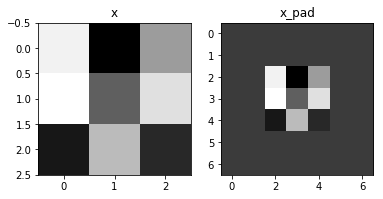

In [7]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1, 1] =", x[1, 1])
print ("x_pad[1, 1] =", x_pad[1, 1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

### Single step of convolution 

Implementing a single step of convolution, filter is applied to a single position of the input. This will be used to build a convolutional unit, which: 

- Takes an input volume 
- Applies a filter at every position of the input
- Outputs another volume (usually of different size)

In [57]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    # Element-wise product between a_slice and W. Add bias.
    # Sum over all entries of the volume s
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """
    
    s = np.multiply(a_slice_prev, W) + b
    z = np.sum(s)
    
    return z

In [58]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -23.16021220252078


### Convolutional Neural Networks - Forward pass

In the forward pass, you will take many filters and convolve them on the input. Each 'convolution' gives you a 2D matrix output. You will then stack these outputs to get a 3D volume

**Reminder**:
The formulas relating the output shape of the convolution to the input shape is:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters used in the convolution}$$

In [39]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    (m, nh_prev, nw_prev, nc_prev) = A_prev.shape
    (f, f, nc_prev, nc) = W.shape
    
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    nh = int((nh_prev - f + 2*pad) / stride) + 1
    nw = int((nw_prev - f + 2*pad) / stride) + 1
    
    # Create a output tensor of shape (m, nh, nw, nc)
    Z = np.zeros((m, nh, nw, nc))
    
    # Apply zero padding to the input activation from previous layer if necessary
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):
        
        # Single image
        a_prev_pad = A_prev_pad[i]
        
        for h in range(nh): 
            # loop over the OUTPUT activation height
            
            for w in range(nw):
                # loop over the OUTPUT activation width
                
                for c in range(nc):
                    # loop over all the filters
                    
                    vert_start = h * stride
                    vert_end = vert_start + f
                    hor_start = w * stride
                    hor_end = hor_start + f
                    
                    # Select the window of a_pad_prev including all the color channels/filters
                    a_slice_prev = a_prev_pad[vert_start:vert_end, hor_start:hor_end, :]
                    
                    # Z at a single position marked by loop variables is the output of single step convolution
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:, :, :, c], b[:, :, :, c])
                    
    assert(Z.shape == (m, nh, nw, nc))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache
    
    

In [106]:
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
# nh = nw = [(4-2+2*2)/1]+1 = 7
hparameters = {"pad" : 2,
               "stride": 1}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])
print("Z's shape: ", Z.shape)


Z's mean = 0.15585932488906465
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]
Z's shape:  (10, 7, 7, 8)


### Pooling layer 

The pooling (POOL) layer reduces the height and width of the input. It helps reduce computation, as well as helps make feature detectors more invariant to its position in the input. The two types of pooling layers are: 

- Max-pooling layer: slides an ($f, f$) window over the input and stores the max value of the window in the output.

- Average-pooling layer: slides an ($f, f$) window over the input and stores the average value of the window in the output.

**Reminder**:
As there's no padding, the formulas binding the output shape of the pooling to the input shape is:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$
$$ n_C = n_{C_{prev}}$$

In [93]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    (m, nh_prev, nw_prev, nc_prev) = A_prev.shape
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    nh = int((nh_prev - f) / stride) + 1
    nw = int((nw_prev - f) / stride) + 1
    nc = nc_prev
    
    A = np.zeros((m,nh,nw,nc))
    
    for i in range(m):
        # For every single training example
        
        a_prev = A_prev[i, :, :, :]
        
        for h in range(nh):
            # For every column of pixels in output height
            
            for w in range(nw):
                # For every pixel in the column
                
                for c in range(nc):
                    # For every single channel
                    
                    vert_start = h * stride
                    vert_end = vert_start + f
                    hor_start = w * stride
                    hor_end = hor_start + f
                    
                    a_slice_prev = a_prev[vert_start:vert_end, hor_start:hor_end, c]
                    
                    if mode == 'max':
                        A[i, h, w, c] = np.max(a_slice_prev)
                        
                    elif mode == 'average':
                        A[i, h, w, c] = np.mean(a_slice_prev)
                        
    assert(A.shape == (m,nh,nw,nc))
        
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
        
    return A, cache
    

In [94]:
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[1.74481176 0.86540763 1.13376944]]]


 [[[1.13162939 1.51981682 2.18557541]]]]

mode = average
A = [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]


## Backpropagation in convolutional neural networks

In modern deep learning frameworks, you only have to implement the forward pass, and the framework takes care of the backward pass, so most deep learning engineers don't need to bother with the details of the backward pass. The backward pass for convolutional networks is complicated. If you wish however, you can work through this optional portion of the notebook to get a sense of what backprop in a convolutional network looks like. 

### Convolutional layer backward pass 

Let's start by implementing the backward pass for a CONV layer. 

#### Computing dA:
This is the formula for computing $dA$ with respect to the cost for a certain filter $W_c$ and a given training example:

$$ dA += \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

Where $W_c$ is a filter and $dZ_{hw}$ is a scalar corresponding to the gradient of the cost with respect to the output of the conv layer Z at the hth row and wth column (corresponding to the dot product taken at the ith stride left and jth stride down). Note that at each time, we multiply the the same filter $W_c$ by a different dZ when updating dA. We do so mainly because when computing the forward propagation, each filter is dotted and summed by a different a_slice. Therefore when computing the backprop for dA, we are just adding the gradients of all the a_slices. 

In code, inside the appropriate for-loops, this formula translates into:
```python
da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
```

#### Computing dW:
This is the formula for computing $dW_c$ ($dW_c$ is the derivative of one filter) with respect to the loss:

$$ dW_c  += \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

Where $a_{slice}$ corresponds to the slice which was used to generate the acitivation $Z_{ij}$. Hence, this ends up giving us the gradient for $W$ with respect to that slice. Since it is the same $W$, we will just add up all such gradients to get $dW$. 

In code, inside the appropriate for-loops, this formula translates into:
```python
dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
```

#### Computing db:

This is the formula for computing $db$ with respect to the cost for a certain filter $W_c$:

$$ db = \sum_h \sum_w dZ_{hw} \tag{3}$$

As you have previously seen in basic neural networks, db is computed by summing $dZ$. In this case, you are just summing over all the gradients of the conv output (Z) with respect to the cost. 

In code, inside the appropriate for-loops, this formula translates into:
```python
db[:,:,:,c] += dZ[i, h, w, c]
```

In [110]:
def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function
    
    Arguments:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward(), output of conv_forward()
    
    Returns:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """
    
    (A_prev, W, b, hparameters) = cache
    (m, nh_prev, nw_prev, nc_prev) = A_prev.shape # A_prev -> input to the conv layer from previous layer
    (f, f, nc_prev, nc) = W.shape
    (m, nh, nw, nc) = dZ.shape
    
    dA_prev = np.zeros_like(A_prev)
    dW = np.zeros_like(W)
    db = np.zeros_like(b)
    
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):
        # For every single training example
        
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(nh):
            # For every single vertical column of pixels of the dZ
            
            for w in range(nw):
                # For every single pixel channel in the column of the dZ
                
                for c in range(nc):
                    # For every single pixel in the pixel channel of the dZ
                    
                    vert_start = h * stride
                    vert_end = vert_start + f
                    hor_start = w * stride
                    hor_end = hor_start + f
                    
                    a_prev_slice = a_prev_pad[vert_start:vert_end, hor_start:hor_end, :]
                    
                    ############################# Computing dA_prev_pad, dW, db ############################
                    da_prev_pad[vert_start:vert_end, hor_start:hor_end, :] += W[:, :, :, c] * dZ[i, h, w, c]
                    dW[:, :, :, c] += a_prev_slice * dZ[i, h, w, c]
                    db[:, :, :, c] += dZ[i, h, w, c]
                    ########################################################################################
        
        # Set the dA_prev for a particular example to the unpadded da_prev_pad
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
        
    assert(dA_prev.shape == (m, nh_prev, nw_prev, nc_prev))
    
    return dA_prev, dW, db


In [111]:
np.random.seed(1)
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))
# print(dA.shape)

dA_mean = 9.608990675868995
dW_mean = 10.581741275547566
db_mean = 76.37106919563735


## Pooling layer - backward pass

Next, let's implement the backward pass for the pooling layer, starting with the MAX-POOL layer. Even though a pooling layer has no parameters for backprop to update, you still need to backpropagation the gradient through the pooling layer in order to compute gradients for layers that came before the pooling layer. 

### Max pooling - backward pass  

Before jumping into the backpropagation of the pooling layer, you are going to build a helper function called `create_mask_from_window()` which does the following: 

$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}\tag{4}$$

As you can see, this function creates a "mask" matrix which keeps track of where the maximum of the matrix is. True (1) indicates the position of the maximum in X, the other entries are False (0). You'll see later that the backward pass for average pooling will be similar to this but using a different mask.  


In [112]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    
    Arguments:
    x -- Array of shape (f, f)
    
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """
    
    mask = np.zeros_like(x)
    
    max_x = np.max(x)
    
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            ## For every element in the matrix
            
            if x[i][j] == max_x:
                mask[i][j] = 1
                
    return mask

In [113]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[1. 0. 0.]
 [0. 0. 0.]]


### Average pooling - backward pass 

In max pooling, for each input window, all the "influence" on the output came from a single input value--the max. In average pooling, every element of the input window has equal influence on the output. So to implement backprop, you will now implement a helper function that reflects this.

For example if we did average pooling in the forward pass using a 2x2 filter, then the mask you'll use for the backward pass will look like: 
$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

This implies that each position in the $dZ$ matrix contributes equally to output because in the forward pass, we took an average. 

In [114]:
def distribute_value(dz, shape):
    """
    Distributes the input value in the matrix of dimension shape
    
    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """
    (nh, nw) = shape
    avg = dz / (nh*nw)
    
    a = np.ones(shape=(nh,nw)) * avg
    
    return a

In [115]:
a = distribute_value(2, (2,2))
print('distributed value =', a)

distributed value = [[0.5 0.5]
 [0.5 0.5]]


### Pooling backward

Compute backward propagation on a pooling layer with the helper functions

In [119]:
def pool_backward(dA, cache, mode = "max"):
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
    dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
    cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
    """
    
    A_prev, hparameters = cache
    
    stride = hparameters['stride']
    f = hparameters['f']
    
    (m, nh_prev, nw_prev, nc_prev) = A_prev.shape
    (m, nh, nw, nc) = dA.shape
    
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):
        # For each training example
        a_prev = A_prev[i]
        
        for h in range(nh):
            # For every column of pixel channels
            
            for w in range(nw):
                # For every pixel channel
                
                for c in range(nc):
                    # For every pixel in the pixel channel
                    
                    vert_start = h * stride
                    vert_end = vert_start + f
                    hor_start = w * stride
                    hor_end = hor_start + f
                    
                    if mode == 'max':
                        
                        a_prev_slice = a_prev[vert_start:vert_end, hor_start:hor_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        da = dA[i, h, w, c]
                        
                        dA_prev[i, vert_start:vert_end, hor_start:hor_end, c] += np.multiply(mask, da)
                        
                    if mode == 'average':
                        
                        da = dA[i, h, w, c]
                        shape = (f, f)
                        
                        dA_prev[i, vert_start:vert_end, hor_start:hor_end, c] += distribute_value(da, shape)
                        
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev
                        
    

In [120]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
